In [ ]:
import json
import mne
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns

In [ ]:
positive_subject_dir = './healthy_20240612'
df= pd.read_csv('./healthy_20240612/label_poms.csv')

In [ ]:
# Extracting specific emotion-related columns
emotions_data = df[['1. Tense', '2. Anger', '3. Weary', '4. Unhappy', '5. Cheerful',
                      '6. Confused', '7. Embarrassed', '8. Uneasy', '9. Grouchy',
                      '10. Fatigued', '11. Sad', '12. Vigorous', '13. Can\'t concentrate',
                      '14. Confident', '15. Restless', '16. Peeved', '17. Worn out',
                      '18. Discouraged', '19. Active', '20. Bewildered', '21. On-edge',
                      '22. Annoyed', '23. Bushed', '24. Miserable', '25. Energetic',
                      '26. Forgetful', '27. Competent', '28. Nervous', '29. Resentful',
                      '30. Exhausted', '31. Worthless', '32. Lively', '33. Uncertain',
                      '34. Satisfied', '35. Anxious', '36. Furious', '37. Bitter',
                      '38. Helpless', '39. Full of pep', '40. Proud']]

# Generate descriptive statistics for each column to understand the range and distribution of responses
descriptive_stats = emotions_data.describe()

# Analyzing for any potential inconsistencies or outliers based on statistical summary
outliers = {}
for column in emotions_data.columns:
    q1 = descriptive_stats.at['25%', column]
    q3 = descriptive_stats.at['75%', column]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Filter the data to find outliers for each emotion
    outliers[column] = emotions_data[(emotions_data[column] < lower_bound) | (emotions_data[column] > upper_bound)]

# Count the number of outliers per emotion to identify where most unusual scores are present
outlier_counts = {emotion: len(df) for emotion, df in outliers.items() if not df.empty}

outlier_counts, descriptive_stats

In [ ]:


# Setting up the visualizations with a larger figure size for clarity
plt.figure(figsize=(20,15))

# Using a heatmap to visualize the correlations among the emotion ratings
correlation_matrix = emotions_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Emotion Ratings')
plt.show()


In [ ]:
plt.figure(figsize=(20, 10))
# Defining negative and positive emotion categories
negative_emotions = ['1. Tense', '2. Anger', '3. Weary', '4. Unhappy', '6. Confused', 
                     '7. Embarrassed', '8. Uneasy', '9. Grouchy', '10. Fatigued', 
                     '11. Sad', '13. Can\'t concentrate', '15. Restless', '16. Peeved', 
                     '17. Worn out', '18. Discouraged', '20. Bewildered', '21. On-edge', 
                     '22. Annoyed', '23. Bushed', '24. Miserable', '26. Forgetful', 
                     '28. Nervous', '29. Resentful', '30. Exhausted', '31. Worthless', 
                     '33. Uncertain', '35. Anxious', '36. Furious', '37. Bitter', 
                     '38. Helpless']

positive_emotions = ['5. Cheerful', '12. Vigorous', '14. Confident', '19. Active', 
                     '25. Energetic', '27. Competent', '32. Lively', '34. Satisfied', 
                     '39. Full of pep', '40. Proud']

# Calculating average scores for negative and positive emotions for each participant using .loc
emotions_data.loc[:, 'Average Negative'] = emotions_data[negative_emotions].mean(axis=1)
emotions_data.loc[:, 'Average Positive'] = emotions_data[positive_emotions].mean(axis=1)


# Selecting a few participants to visualize
sample_data = emotions_data[['Average Negative', 'Average Positive']]

# Plotting

sample_data.plot(kind='bar', colormap='Paired')
plt.title('Comparison of Average Negative and Positive Emotion Ratings per Participant')
plt.ylabel('Average Rating')
plt.xlabel('Participant')
plt.xticks(ticks=range(30), labels=sample_data.index, rotation=0)
plt.legend(['Average Negative Emotions', 'Average Positive Emotions'])
plt.show()


In [ ]:
# Recalculating the difference and defining dataframes based on the threshold
emotions_data['Difference'] = abs(emotions_data['Average Negative'] - emotions_data['Average Positive'])
high_difference_data = emotions_data[emotions_data['Difference'] >= 0.3]
Low_difference_data = emotions_data[emotions_data['Difference'] < 0.3]

# Setting up the plot area with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot for high difference data
high_difference_data[['Average Negative', 'Average Positive']].plot(kind='bar', ax=axes[0], colormap='Paired')
axes[0].set_title('High Difference in Emotions')
axes[0].set_ylabel('Average Rating')
axes[0].set_xlabel('Participant')
axes[0].set_xticks(range(len(high_difference_data)))
axes[0].set_xticklabels(high_difference_data.index, rotation=0)
axes[0].legend(['Average Negative Emotions', 'Average Positive Emotions'])

# Plot for low difference data
Low_difference_data[['Average Negative', 'Average Positive']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Low Difference in Emotions')
axes[1].set_ylabel('Average Rating')
axes[1].set_xlabel('Participant')
axes[1].set_xticks(range(len(Low_difference_data)))
axes[1].set_xticklabels(Low_difference_data.index, rotation=0)
axes[1].legend(['Average Negative Emotions', 'Average Positive Emotions'])

plt.tight_layout()
plt.show()

# Output the count of subjects in each category
print("Total subjects with high difference: ", len(high_difference_data))
print("Total subjects with low difference: ", len(Low_difference_data))


## Checking the quality of signal


In [2]:
def load_json(directory):
    with open(directory, mode='r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def apply_fft(data, fs:int =250):
    fft_result = np.abs(np.fft.fft(data))[0:]
    freq = np.fft.fftfreq(len(data), d=1/fs)[0:]
    max_peak_index = np.argmax(np.abs(fft_result))
    
    # Setting the maximum peak to zero in the FFT result
    fft_result[max_peak_index] = 0
    fft = (fft_result)
    return fft , freq


def processing_data(directory):
    data = load_json(directory)
    processs = data['ProcessedDatas']
    l,r = [],[]
    for fil in processs:
        left_wave = fil['LeftWave']
        right_wave = fil['RightWave']

        l+=left_wave
        r+=right_wave

    l = l[900:]
    r = r[900:]
    combined_array = np.stack((l, r), axis=0)
    lfft , lfreq = apply_fft(l)
    rfft, rfreq = apply_fft(r)
    
    return l,r,lfft,lfreq,rfft,rfreq, combined_array

In [11]:
#directory1 = './healthy/A04_EEG.json'
directory1 = './healthy/A43_1.json'
directory2 = './healthy/A43_3.json'
l,r,lfft,lfreq,rfft,rfreq, combined_array = processing_data(directory1)
l2,r2,lfft2,lfreq2,rfft2,rfreq2, combined_array2 = processing_data(directory2)

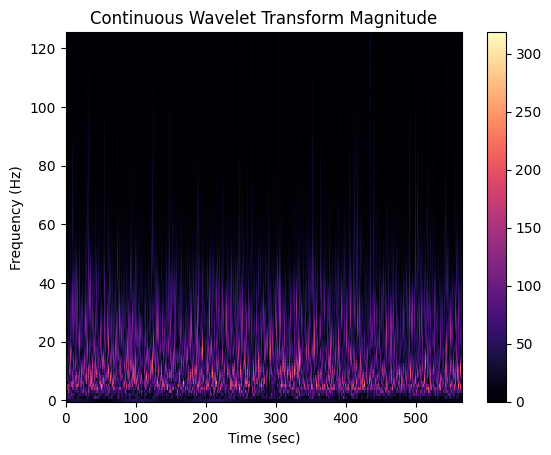

In [4]:
import neurokit2 as nk
f, t, cwtm = nk.signal_timefrequency(l,
                                     250,
                                     max_frequency=125,
                                     method="cwt",
                                     show=True)

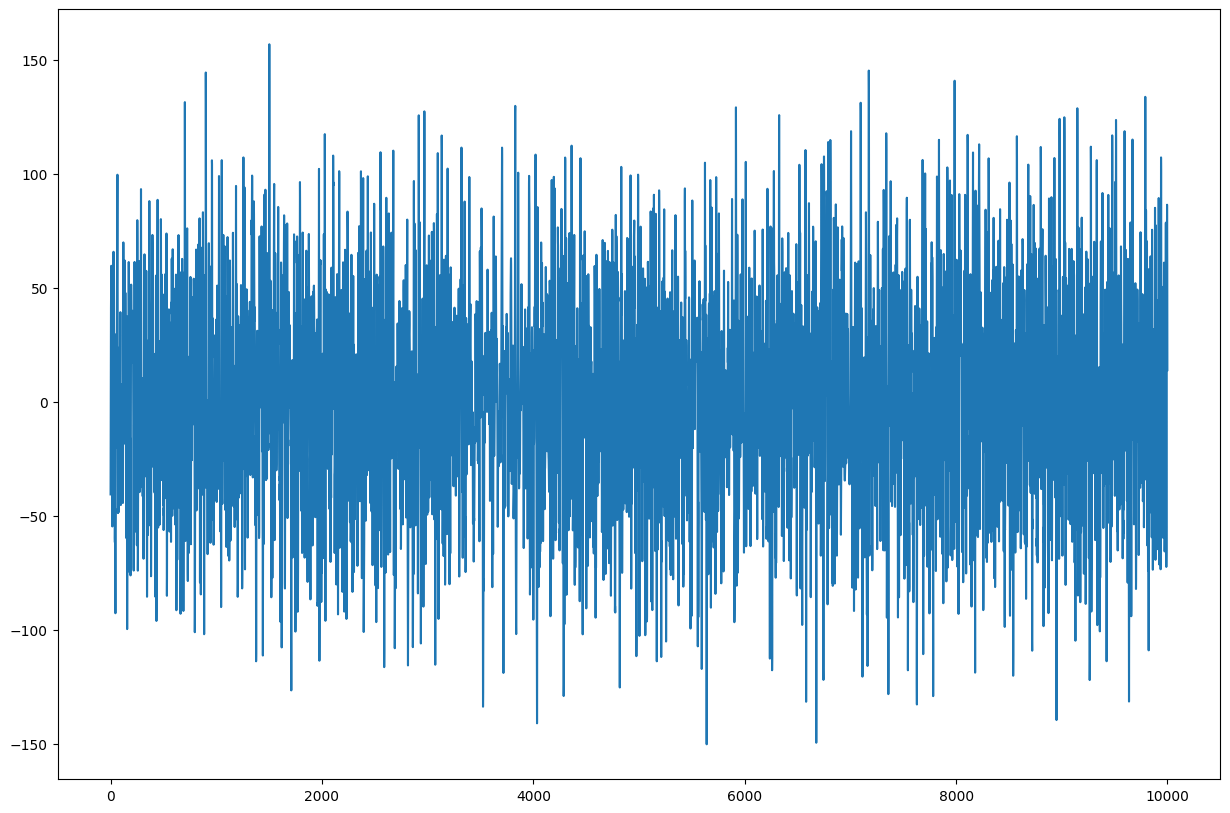

In [5]:
plt.figure(figsize=(15,10))
plt.plot(l2[:10000])

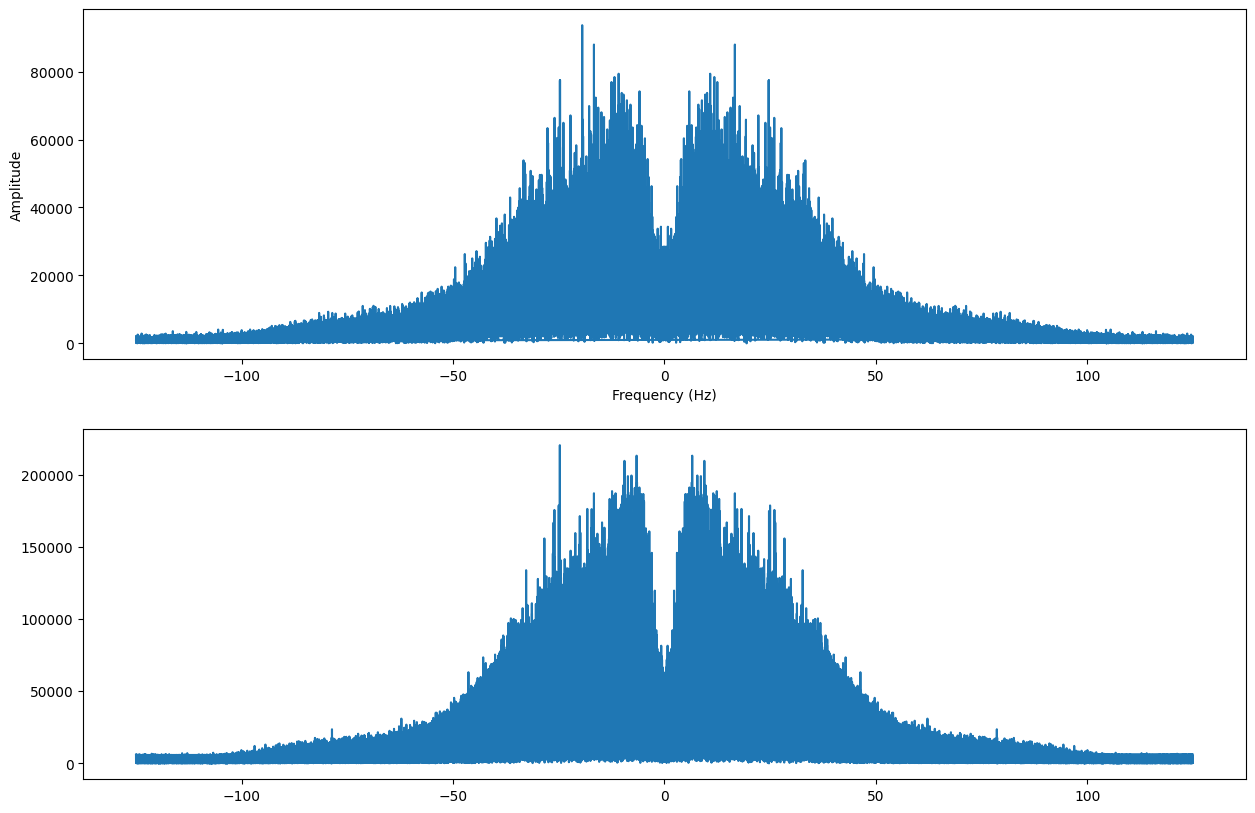

In [12]:

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(lfreq,lfft )
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.subplot(212)
plt.plot(lfreq2,lfft2 )

In [ ]:
sfreq = 250  # Sampling frequency in Hz
channel_types = 'eeg'  # Type of channels
channel_names = ['Fp1', 'Fp2']
# Create an MNE Info object
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=channel_types)
raw = mne.io.RawArray(combined_array, info)
raw1 = mne.io.RawArray(combined_array2, info)

In [ ]:
raw.plot_psd(), raw1.plot_psd()